## <span style="color:green">**Version en cours**</span>

# Segmentez des clients d'un site e-commerce
## Notebook 2 : Feature ingineering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Présentation du projet

**Contexte**  


* Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.  
* Dans un premier temps il est demandé de réaliser quelques requêtes pour le dashboard à partir de la base de données SQLite d'Olist.  
* La mission principale est de fournir aux équipes d'e-commerce d'Olist une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

**Démarche globale**  
* Requêtes SQL pour le dashboard (cf Notebook 1)  
* **Feature ingineering** : c'est l'objet de ce notebook
* Tests de modèles de clustering (Notebook 3)  
* Simulation d'un contrat de maintenace (Notebbok 4)  

**Feature ingineering**  
* Objectif :
   * Préparer un dataset qui servira de base aux algorithmes de clustering testés à l'étape suivante  
   * Chaque ligne représentera un client, chaque colonne une feature caractérisant les clients
* Préparation des données pour les algorithmes envisagés (KMeans, DBSCAN, Agglomerative Hierarchical Clustering) :
   * Élimination des valeurs manquantes
   * Traitement des valeurs aberrantes
   * Normalisation / standardisation
   * Encodage des variables catégorielles
* Sélection des features pour réaliser une segmentation des clients de type RFM :
   * **R**écence : Nombre de jours écoulés depuis le dernier achat  
   * **F**réquence : Nombre total d'achats effectués par un client sur une période donnée  
   * **M**ontant : Montant total dépensé par un client  

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions

**Chargement des données**
* Schéma relationnel   
* Création des dataframes des tables

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

In [2]:
# Installation des librairies
!pip install pandas --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

In [3]:
# Import des modules
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

## 1.3 Fonctions

In [4]:
# Renvoit le résultat d'une requête SQL
def query_result(query: str, all_rows: bool=True):
    with sqlite3.connect('olist.db') as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        if all_rows:
            result = cursor.fetchall()
        else:
            result = cursor.fetchone()
            if len(result) == 1:
                result = result[0]
    return result

In [5]:
# Renvoit le résultat d'une requête SQL sous forme de dataframe
def f_query_result(query: str):
    """Renvoit un dataframe contenant le résultat de la requête SQL passée en paramètre sous forme d'un string
    Le fichier de la BDD SQLite 'olist.db' doit être présent dans le répertoire courant.
    """
    with sqlite3.connect('olist.db') as conn:
        df = pd.read_sql_query(query, conn)
    return df

In [6]:
def create_dataframe_and_csv_if_not_exist_from_table(tablename: str):
    """Renvoit un dataframe contenant le contenu de la table passée en paramètre sous forme d'un string
    - Si le fichier csv de la table df_{tablename}.csv n'existe pas :
        * Utilisation de la fonction 'f_query_result' pour récupérer le contenu de la table dans un dataframe
        * Enregistrement du fichier csv
    - Si le fichier csv existe, lecture de son contenu dans un dataframe
    """
    filename = f"df_{tablename}.csv"
    if not os.path.exists(filename):
        query = f'SELECT * FROM {tablename};'
        df = f_query_result(query)
        df.drop(columns='index', inplace=True)
        df.to_csv(filename, index=False)
    else:
        df = pd.read_csv(filename)
    return df

In [7]:
# Description des champs d'une table de la BDD SQLite 'olist.db' (à base de requêtes SQL)
def describe_table(table_name: str, fields=None):
    """Examine :
       - les champs compris dans la liste 'fields' de la table 'table_name'
       - ou tous les champs si 'fields' n'est pas renseigné
    Renvoit un dataframe 'df_infos' composé des variables :
       - 'Colonne' : nom des variables de df
       - 'Type' : type de la colonne
       - 'Valeurs uniques' : nombre de valeurs unique de la colonne
       - 'Valeurs manquantes' : nombre de valeurs manquantes de la colonne
       - '% valeurs manquantes' : pourcentage de valeurs manquantes de la colonne
       - 'Doublons' : nombre de valeurs non uniques (doublons) de la colonne
    """
    # Préparation des colonnes du dataframe de descriptions
    df_names, df_types, df_unique_values, df_duplicates, df_missing_values, df_percentage_missing = [], [], [], [], [], []
    
    # Récupération de la liste des champs de la table
    pragma = query_result(f"PRAGMA table_info({table_name});")
    table_fields = [row[1] for row in pragma]

    # Constitution de la liste des champs à décrire
    if fields is None:
        fields = [field for field in table_fields if field != 'index']
    elif isinstance(fields, str):
        fields = [fields]
        
    # Récupération/calculs des informations descriptives
    total_rows = query_result(f"SELECT COUNT(*) FROM {table_name};", False)
    for field_index, field_name in enumerate(table_fields):
        if field_name in fields:
            field_type = pragma[field_index][2]
            unique_values = query_result(f"SELECT COUNT(DISTINCT {field_name}) FROM {table_name};", False)
            non_null_values = query_result(f"SELECT COUNT({field_name}) FROM {table_name};", False)
            duplicates = non_null_values - unique_values
            missing_values = total_rows - non_null_values
            percentage_missing = (missing_values / total_rows) * 100 if total_rows > 0 else 0
            percentage_missing = str(round(percentage_missing, 2)) + ' %'

            df_names.append(field_name)
            df_types.append(field_type)
            df_unique_values.append(unique_values)
            df_duplicates.append(duplicates)
            df_missing_values.append(missing_values)
            df_percentage_missing.append(percentage_missing)

    # Céation du dataframe de description
    df_infos = pd.DataFrame({
        'Colonne': df_names,
        'Type': df_types,
        'Valeurs uniques': df_unique_values,
        'Doublons': df_duplicates,
        'Valeurs manquantes': df_missing_values,
        '% valeurs manquantes': df_percentage_missing
    }).reset_index(drop=True)

    return df_infos

In [8]:
# Description des variables d'un dataframe
def get_dataframe_infos(df):
    """Examine le dataframe (ou la series) 'df' fourni en paramètre et renvoit un dataframe 'df_infos' composé des variables :
       - 'Colonne' : nom des variables de df
       - 'Type' : type de la colonne
       - 'Valeurs uniques' : nombre de valeurs unique de la colonne
       - 'Valeurs manquantes' : nombre de valeurs manquantes de la colonne
       - '% valeurs manquantes' : pourcentage de valeurs manquantes de la colonne
       - 'Doublons' : nombre de valeurs non uniques (doublons) de la colonne
    """
    if isinstance(df, pd.Series):
        df = df.to_frame()
    number_of_rows = df.shape[0]
    col_names = df.columns
    col_types = df.dtypes
    unique_values = df.nunique()
    missing_values = df.isnull().sum()
    non_missing_values = number_of_rows - missing_values
    duplicate_values = non_missing_values - unique_values

    df_infos = pd.DataFrame({
        'Colonne': col_names,
        'Type': col_types,
        'Valeurs uniques': unique_values,
        'Doublons': duplicate_values,
        'Valeurs manquantes': missing_values,
        '% valeurs manquantes': round((missing_values / number_of_rows) * 100, 2).astype(str) + " %"
    }).reset_index(drop=True)

    return df_infos

In [9]:
# Transforme les types des variables d'un dataframe
def transform_data_types(df, transformations):
    # Conversion en type string ou category si le nbre de valeurs uniques est faible
    if 'to_string' in transformations:
        for column in transformations['to_string']:
            if df[column].nunique() / len(df[column]) < 0.02:
                df[column] = df[column].astype('category')
            else:
                df[column] = df[column].astype(str)
            df[column] = df[column].replace('None', np.nan)
    
    # Conversion en dates avec gestion NaT
    if 'to_date' in transformations:
        if len(df[transformations['to_date']].iloc[0]) <= 10 :
            for column in transformations['to_date']:
                df[column] = pd.to_datetime(df[column], errors='coerce')
        else:
            for column in transformations['to_date']:
                df[column] = pd.to_datetime(df[column], errors='coerce').dt.round('s')
   
    # Conversion en entier avec gestion NaN
    if 'to_integer' in transformations:
        for col in transformations['to_integer']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # Conversion en flottants
    if 'to_float' in transformations:
        for col in transformations['to_float']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    
    return df

In [10]:
# Affiche l'histogramme et le boxplot d'une feature
def plot_distribution(dataframe, feature, x_label, y_label, x_tick_angle=None):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    plt.subplots_adjust(hspace=0.05)  # Ajuste l'espace entre les graphiques
    
    # Histogramme
    sns.histplot(dataframe[feature], bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f'Distribution {feature}', pad=10)
    axs[0].set_xlabel('')  # Supprime le label de l'axe x pour l'histogramme
    axs[0].set_ylabel(y_label)
    axs[0].grid(linewidth=0.25)
    
    # Boxplot
    sns.boxplot(x=dataframe[feature], ax=axs[1])
    axs[1].set_xlabel(x_label)
    axs[1].set_yticks([])  # Supprime les ticks de l'axe y pour le boxplot

    if x_tick_angle is not None:
        for axis in axs:
            for label in axis.get_xticklabels():
                label.set_rotation(x_tick_angle)

    plt.show()

# 2 Chargement des données

## 2.1 Schéma relationnel

La réalisation des quelques requêtes pour le dashboard (Notebook 1) a été l'occasion d'étudier les relations entre les tables de la BDD Olist et d'établir le schema relationnel :

![shema relationnel](schema_relationnel_olist.png "Shéma relationnel BDD olist")

## 2.2 Création des dataframes des tables

* Chargement des fichiers csv dans le dataframe correspondant  
* Si le fichier csv n'existe pas, il est créé après avoir lu le contenu de la table dans la BDD

In [11]:
df_customers = create_dataframe_and_csv_if_not_exist_from_table('customers')
df_orders = create_dataframe_and_csv_if_not_exist_from_table('orders')
df_order_pymts = create_dataframe_and_csv_if_not_exist_from_table('order_pymts')
df_order_items = create_dataframe_and_csv_if_not_exist_from_table('order_items')
df_order_reviews = create_dataframe_and_csv_if_not_exist_from_table('order_reviews')
# df_geoloc = create_dataframe_and_csv_if_not_exist_from_table('geoloc')
# df_products = create_dataframe_and_csv_if_not_exist_from_table('products')
# df_sellers = create_dataframe_and_csv_if_not_exist_from_table('sellers')
# df_translation = create_dataframe_and_csv_if_not_exist_from_table('translation')

# 3 Création des features

## 3.1 Préparation du dataframe pour les modèles

* Seuls les clients ayant validé une commande (même si celle-ci n'est pas encore payée ni livrée) seront pris en compte
* Le dataframe devra comprendre une ligne par client  
* Le champ `customer_unique_id` de la table `customers` identifie les clients de manière unique

* Affichage des informations de la table `customers` :

In [12]:
# Version table SQLite
display(describe_table('customers'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,customer_id,TEXT,99441,0,0,0.0 %
1,customer_unique_id,TEXT,96096,3345,0,0.0 %
2,customer_zip_code_prefix,BIGINT,14994,84447,0,0.0 %
3,customer_city,TEXT,4119,95322,0,0.0 %
4,customer_state,TEXT,27,99414,0,0.0 %


In [13]:
# Version dataframe pandas
display(get_dataframe_infos(df_customers))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,customer_id,object,99441,0,0,0.0 %
1,customer_unique_id,object,96096,3345,0,0.0 %
2,customer_zip_code_prefix,int64,14994,84447,0,0.0 %
3,customer_city,object,4119,95322,0,0.0 %
4,customer_state,object,27,99414,0,0.0 %


* Affichage de quelques lignes

In [14]:
display(df_orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


* Il n'y a pas de données manquantes 
* Création du dataframe avec les valeurs uniques de `customer_unique_id`

In [15]:
# Y-a-t-il des 'customer_unique_id' avec des commandes non validées ?
query = """SELECT customer_unique_id, COUNT(o.order_id) AS nombre_de_commandes_non_validees
FROM customers c
LEFT JOIN orders o
ON o.customer_id = c.customer_id
WHERE order_purchase_timestamp IS NULL
GROUP BY customer_unique_id
ORDER BY nombre_de_commandes_non_validees;
"""
result = f_query_result(query)
display(result)

,customer_unique_id,nombre_de_commandes_non_validees


* Visiblement, aucun client n'est enregistré s'il n'a pas validé sa commande
* Utilisation du champ `customer_unique_id` de la table `customers` comme première colonne du dataframe `df_features`

In [16]:
# Création du dataframe 'df_features'
df_features = pd.DataFrame({'customer_id': df_customers['customer_unique_id'].unique()})

* Affichage de quelques lignes

In [17]:
display(df_features)

,customer_id
0,861eff4711a542e4b93843c6dd7febb0
1,290c77bc529b7ac935b93aa66c333dc3
2,060e732b5b29e8181a18229c7b0b2b5e
3,259dac757896d24d7702b9acbbff3f3c
4,345ecd01c38d18a9036ed96c73b8d066
...,...
96091,1a29b476fee25c95fbafc67c5ac95cf8
96092,d52a67c98be1cf6a5c84435bd38d095d
96093,e9f50caf99f032f0bf3c55141f019d99
96094,73c2643a0a458b49f58cea58833b192e


## 3.2 Feature `Récence`

* Récence : nombre de jours écoulés depuis le dernier achat  
* La date de référence sera celle du dernier achat (`orders.order_purchase_timestamp`)  
* Une rapide analyse exploratoire de la table `orders` sera réalisée au préalable

### 3.2.1 Analyse de la table `orders`

* Affichage des informations de la table `orders` :

In [18]:
# Version table SQLite
display(describe_table('orders'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,99441,0,0,0.0 %
1,customer_id,TEXT,99441,0,0,0.0 %
2,order_status,TEXT,8,99433,0,0.0 %
3,order_purchase_timestamp,TEXT,98875,566,0,0.0 %
4,order_approved_at,TEXT,90733,8548,160,0.16 %
5,order_delivered_carrier_date,TEXT,81018,16640,1783,1.79 %
6,order_delivered_customer_date,TEXT,95664,812,2965,2.98 %
7,order_estimated_delivery_date,TEXT,459,98982,0,0.0 %


In [19]:
# Version dataframe pandas
display(get_dataframe_infos(df_orders))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99441,0,0,0.0 %
1,customer_id,object,99441,0,0,0.0 %
2,order_status,object,8,99433,0,0.0 %
3,order_purchase_timestamp,object,98875,566,0,0.0 %
4,order_approved_at,object,90733,8548,160,0.16 %
5,order_delivered_carrier_date,object,81018,16640,1783,1.79 %
6,order_delivered_customer_date,object,95664,812,2965,2.98 %
7,order_estimated_delivery_date,object,459,98982,0,0.0 %


* Affichage de quelques lignes

In [20]:
display(df_orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


* Les variables `order_purchase_timestamp`, `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date`, `order_estimated_delivery_date` doivent être transformées en type `date`  
* La variable `order_status` pourra être transformée en type `string`, car la fonction `tansform_data_type()` est prévue pour convertir automatiquement en type `category` lorsque le nombre de modalités est faible  
* A noter **160** valeurs manquantes pour la variable `order_approved_at`

* Conversions de type

In [21]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'customer_id', 'order_status'],
    'to_date': ['order_purchase_timestamp',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date']
}

# Conversions
df_orders = transform_data_types(df_orders, to_transform)

* Vérification des conversions

In [22]:
display(get_dataframe_infos(df_orders))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99441,0,0,0.0 %
1,customer_id,object,99441,0,0,0.0 %
2,order_status,category,8,99433,0,0.0 %
3,order_purchase_timestamp,datetime64[ns],98875,566,0,0.0 %
4,order_approved_at,datetime64[ns],90733,8548,160,0.16 %
5,order_delivered_carrier_date,datetime64[ns],81018,16640,1783,1.79 %
6,order_delivered_customer_date,datetime64[ns],95664,812,2965,2.98 %
7,order_estimated_delivery_date,datetime64[ns],459,98982,0,0.0 %


* Distribution et valeurs aberrantes de la variable `order_purchase_timestamp`

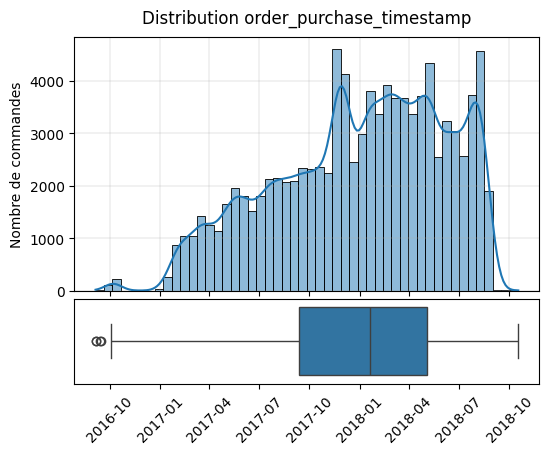

In [23]:
# Affichage histogramme et boxplot
plot_distribution(df_orders, 'order_purchase_timestamp', x_label='', y_label='Nombre de commandes', x_tick_angle=45)

* Valeurs aberrantes
   * Certaines commandes ont été passées **avant janvier 2017**, or il est précisé :
      > *"Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients **depuis janvier 2017**."*  
   * Il n'y a pas de valeurs aberrantes en fin de période, dans le sens ou il n'y a pas de dates d'achat après le 3ème quatile + 1.5 x l'IQR, mais on constate **une chute du nombre de commandes**.  

* Les commandes passées avant le 1er janvier 2017 devront être exclues
* Quelle que soit la raison de la chute du nombre de commandes en fin de période, il sera préférable d'exclure les données de cette période

### 3.2.3 Recherche du dernier mois bien renseigné

* Répartition mensuelles des commandes 

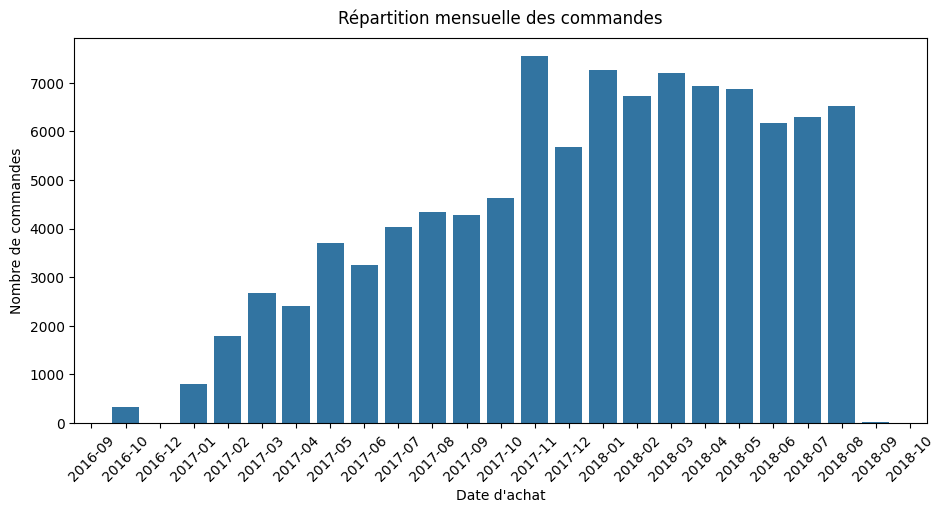

In [24]:
# Ajout de la colonne 'year_month'
df_orders['year_month'] = df_orders['order_purchase_timestamp'].dt.to_period('M')

# Nombre de commandes passées pour chaque valeur de 'year_month'
df_orders_by_year_month = df_orders.groupby('year_month')['order_id'].count().reset_index()

# Affichage barplot
plt.figure(figsize=(11, 5))
sns.barplot(data=df_orders_by_year_month, x='year_month', y='order_id')
plt.xticks(rotation=45)
plt.xlabel('Date d\'achat')
plt.ylabel('Nombre de commandes')
plt.title('Répartition mensuelle des commandes', pad=10)
plt.show()

* On constate un fort décrochage à partir du mois de septembre 2018

### 3.2.2 Exclusion des commandes antérieures à janvier 2017 ou postérieures à août 2018

**Démarche**  
*Les lignes correspondantes aux commandes datées d'avant janvier 2017 ou d'après août 2018 seront supprimées des dataframes*  
* Récupération des `order_id` des commandes passées avant janvier 2017 ou après août 2018  
* Suppression des reviews dans le dataframe `df_reviews`  
* Suppression des réglements dans le dataframe `df_pymts`
* Suppression des produits dans le dataframe `df_order_items`
* Suppression des clients dans le dataframe `df_customers`  
* Suppression des commandes dans le dataframe `df_orders`  
* Reconstitution du dataframe `df_features`

#### 3.2.2.1 Récupération des `order_id` des commandes passées avant le 1er janvier 2017 ou après le 31 août 2018

In [25]:
exclusion_period_mask = (df_orders['order_purchase_timestamp'] < '2017-01-01') | (df_orders['order_purchase_timestamp'] > '2018-08-31')
order_ids_to_exclude = df_orders.loc[exclusion_period_mask, 'order_id']

In [26]:
print(f"{order_ids_to_exclude.shape[0]} commandes ont été passées avant janvier 2017 ou après août 2018")

350 commandes ont été passées avant janvier 2017 ou après août 2018


#### 3.2.2.2 Suppression des reviews dans le dataframe `df_order_reviews`

In [27]:
# Nombre de reviews avant
number_of_reviews = df_order_reviews.shape[0]

# Suppression
df_order_reviews = df_order_reviews[~df_order_reviews['order_id'].isin(order_ids_to_exclude)]

# Résultat
print(f"{number_of_reviews - df_order_reviews.shape[0]} reviews ont été supprimées.")

346 reviews ont été supprimées.


#### 3.2.2.3 Suppression des réglements dans le dataframe `df_order_pymts`

In [28]:
# Nombre de réglements avant
number_of_payments = df_order_pymts.shape[0]

# Suppression
df_order_pymts = df_order_pymts[~df_order_pymts['order_id'].isin(order_ids_to_exclude)]

# Résultat
print(f"{number_of_payments - df_order_pymts.shape[0]} réglements ont été supprimés.")

367 réglements ont été supprimés.


#### 3.2.2.4 Suppression des unités de produits achetés dans le dataframe `df_order_items`

In [29]:
# Nombre d'unités de produits avant
number_of_order_items = df_order_items.shape[0]

# Suppression
df_order_items = df_order_items[~df_order_items['order_id'].isin(order_ids_to_exclude)]

# Résultat
print(f"{number_of_order_items - df_order_items.shape[0]} unités de produits achetés ont été supprimées.")

371 unités de produits achetés ont été supprimées.


#### 3.2.2.5 Suppression des clients dans le dataframe `df_customers`

In [30]:
# Récupération des 'customer_id'
customer_ids_to_exclude = df_orders.loc[exclusion_period_mask, 'customer_id']

In [31]:
# Nombre clients avant
number_of_customers = df_customers['customer_unique_id'].nunique()

# Suppression
df_customers = df_customers[~df_customers['customer_id'].isin(customer_ids_to_exclude)]

# Résultat
print(f"{number_of_customers - df_customers['customer_unique_id'].nunique()} clients ont été supprimées.")

323 clients ont été supprimées.


#### 3.2.2.6 Suppression des commandes dans le dataframe `orders`

In [32]:
# Nombre de commandes avant
number_of_orders = df_orders.shape[0]

# Suppression
df_orders = df_orders.loc[~exclusion_period_mask]

# Résultat
print(f"{number_of_orders - df_orders.shape[0]} commandes ont été supprimées.")

350 commandes ont été supprimées.


#### 3.2.2.6 Reconstitution du dataframe `df_features`

In [33]:
df_features = pd.DataFrame({'customer_unique_id': df_customers['customer_unique_id'].unique()})

In [34]:
display(df_features)

,customer_unique_id
0,861eff4711a542e4b93843c6dd7febb0
1,290c77bc529b7ac935b93aa66c333dc3
2,060e732b5b29e8181a18229c7b0b2b5e
3,259dac757896d24d7702b9acbbff3f3c
4,345ecd01c38d18a9036ed96c73b8d066
...,...
95768,1a29b476fee25c95fbafc67c5ac95cf8
95769,d52a67c98be1cf6a5c84435bd38d095d
95770,e9f50caf99f032f0bf3c55141f019d99
95771,73c2643a0a458b49f58cea58833b192e


* La base de données comptabilise **95 773 clients** ayant passé au moins une commande entre janvier 2017 et août 2018.

### 3.2.4 Calcul de la feature `Récence`

In [35]:
# Merge des features 'customer_unique_id' et 'order_purchase_timestamp' 
df_purchase_timestamp = pd.merge(df_orders[['customer_id', 'order_purchase_timestamp']], df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

In [36]:
# Récupération de la date de dernier achat de chaque 'customer_unique_id'
last_purchase_dates = df_purchase_timestamp.groupby(['customer_unique_id']).agg(
    last_purchase_timestamp = ('order_purchase_timestamp', 'max')
).reset_index()

In [37]:
# Conversion de la date de référence au format datetime "YYYY-MM-DD 00:00:00"
last_order_date = pd.to_datetime('2018-08-31')

# Conversion de la date de dernier achat au format datetime "YYYY-MM-DD 00:00:00"
last_purchase_dates['last_purchase_timestamp'] = last_purchase_dates['last_purchase_timestamp'].dt.normalize()

In [38]:
# Calcul de la feature 'Récence'
last_purchase_dates['Récence'] = (last_order_date - last_purchase_dates['last_purchase_timestamp']).dt.days

In [39]:
# Ajout de la feature 'Récence' au dataframe 'df_features'
df_features = pd.merge(df_features, last_purchase_dates[['customer_unique_id', 'Récence']], on='customer_unique_id')

In [40]:
# Affichage de quelques exemples
display(df_features.sort_values('Récence'))

,customer_unique_id,Récence
22899,3158fc4f60ca92412de397461b64cee3,1
52025,230a1e9f42924d41f37fd22a1d4a9707,1
3471,91544d22848a922381b73b5e21ad58ff,1
30363,eb240714223915add224beff2d844e53,1
47451,0c6d7218d5f3fa14514fd29865269993,2
...,...,...
41083,ef89f6e31311594d74becf9e18c73693,603
14564,da9c90677b1963eca1cf8a14c338cf6e,603
41988,29a63a400c3ca9982907ce8de1f19527,603
18388,d753459418d268407f19b64be28e3c5a,603


## 3.3 Feature `Fréquence`

* Fréquence : nombre total d'achats effectués par un client sur une période donnée  
* La période choisie doit refléter le cycle d'achat des clients et permettre de distinguer les clients réguliers des clients occasionnels  

### 3.3.1 Détermination de la période

* Répartition mensuelles de commandes

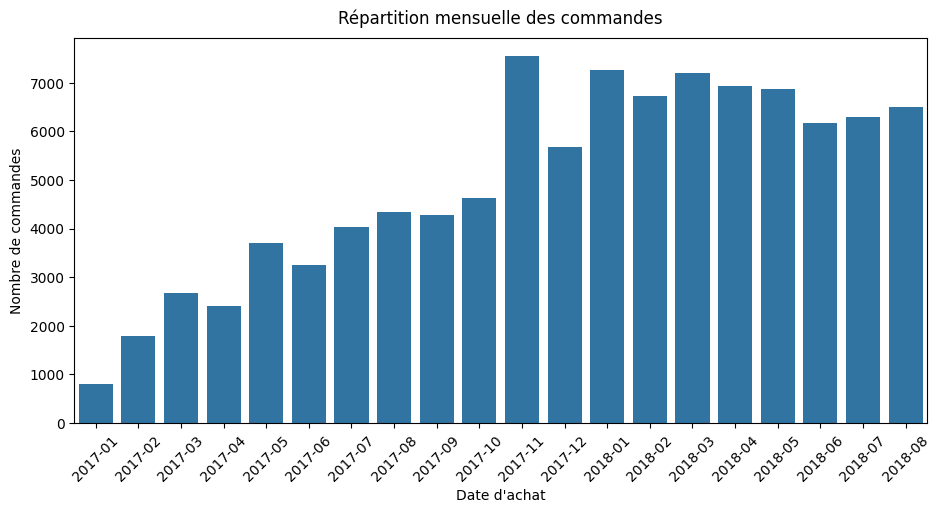

In [41]:
# Nombre de commandes passées pour chaque valeur de 'year_month'
df_orders_by_year_month = df_orders.groupby('year_month')['order_id'].count().reset_index()

# Affichage barplot
plt.figure(figsize=(11, 5))
sns.barplot(data=df_orders_by_year_month, x='year_month', y='order_id')
plt.xticks(rotation=45)
plt.xlabel('Date d\'achat')
plt.ylabel('Nombre de commandes')
plt.title('Répartition mensuelle des commandes', pad=10)
plt.show()

* Nombre de commandes par clients

In [42]:
# Nombre de commandes par 'customer_unique_id'
# Dans les tables 'orders' et 'customers', le champ 'customer_id' représente une commande
number_of_orders_by_customer = df_customers.groupby('customer_unique_id')['customer_id'].count().reset_index()

# Nombre de clients pour chaque "Nombre de commandes"
number_of_customers_by_number_of_orders = number_of_orders_by_customer.groupby('customer_id')['customer_unique_id'].count().reset_index()

# Changement de noms aux colonnes pour plus de clarté
number_of_customers_by_number_of_orders = number_of_customers_by_number_of_orders.rename(columns={'customer_id': 'Nombre de commandes', 'customer_unique_id': 'Nombre de clients'})

# Calcul du pourcentage de clients
number_of_customers = df_features.shape[0]
number_of_customers_by_number_of_orders['% de clients'] = round((number_of_customers_by_number_of_orders['Nombre de clients'] / number_of_customers) * 100, 3)

# Affichage dans l'ordre logique des colonnes
number_of_customers_by_number_of_orders[['Nombre de clients', '% de clients', 'Nombre de commandes']]

,Nombre de clients,% de clients,Nombre de commandes
0,92798,96.894,1
1,2728,2.848,2
2,198,0.207,3
3,30,0.031,4
4,8,0.008,5
5,6,0.006,6
6,3,0.003,7
7,1,0.001,9
8,1,0.001,17


* Les commandes sont en augmentation jusqu'en novembre 2017, puis en relative stagnation
* La période disponible est relativement courte : un peu plus d'un an et demi
* La plupart des clients n'ont fait qu'un seul achat sur cette période  

* Compte-tenu de ces éléments, je choisi de calculer la feature `Fréquence` sur l'intégralité de la période disponible

### 3.3.2 Calcul de la feature `Fréquence`

* Étant donné que seulement un peu plus de **3 %** des clients n'ont passé qu'une seule commande sur la période, je choisi de binariser la feature `Fréquence` :
   * Un score de **0** sera attribué aux clients n'ayant effectué qu'**une commande**  
   * Un score de **1** sera attribué aux clents ayant passé **2 commandes ou plus**

In [43]:
# Fusion des dataframes 'df_features' et 'number_of_orders_by_customer'
df_features = pd.merge(df_features, number_of_orders_by_customer, on='customer_unique_id', how='inner')

# Changement de nom à la colonne 'customer_id' qui contient le nombre de commandes passées
df_features.rename(columns={'customer_id': 'Fréquence'}, inplace=True)

In [44]:
# Masque de séléction des clients ayant passé une seule commande
only_one_order_mask = df_features['Fréquence'] == 1

In [45]:
# Attribution du score de Fréquence 0 aux clients ayant passé une seule commande
df_features.loc[only_one_order_mask, 'Fréquence'] = 0

# Attribution du score de Fréquence 1 aux autres clients
df_features.loc[~only_one_order_mask, 'Fréquence'] = 1

* Affichage de quelques clients

In [46]:
df_features.sort_values('Fréquence')

,customer_unique_id,Récence,Fréquence
0,861eff4711a542e4b93843c6dd7febb0,472,0
63772,aa1a036afef8181797a6e3f8b96d91b8,165,0
63771,08f77862a18100d978ece3564a80366d,210,0
63770,797ecfd850b58e0855e2222bb59fcdd1,133,0
63769,f851601132fd95d1bc72825fdc1653a6,127,0
...,...,...,...
84660,c45ece361aab055ea6c55b61eb2d99c0,333,1
26936,b7741f7ec50ab6bcd52ab08ea8f214d9,218,1
42248,4754e3b66497719a91b36268ed9c5718,266,1
19702,54eb010282ed1c4a38e101aa8b9aca37,8,1


* Vérification

In [47]:
# Nombre de clients avec un score de Fréquence à 0
df_features['Fréquence'].value_counts().to_frame()

,count
Fréquence,
0,92798
1,2975


Il y a bien **92 798 clients** qui n'ont passé qu'une seule commande

# <span style="color:red">**Élements de la version précédente - A ignorer**</span>

# 2 Analyse exploratoire

L'objectif est de réaliser une **segmentation des clients**.  
Je vais donc porter une attention particulière sur les champs me permettant de calculer des scores par client :  
* **Récence** : date de la dernière commande => `orders.order_approved_at` ?  
* **Fréquence** : nombre total de commandes => `customers.customer_id`, `orders.order_id` ou `orders.customer_id` ?  
* **Montant** : valeur totale des achats => `order_items.price` (+ `order_items.freight` ?), `order_pymts.payment_value` ?  
* **Panier moyen** : valeur moyenne d'une commande => Montant total / nombre de commandes  
* **Score de satisfaction** : notes de satisfaction => `order_reviews.review_score` (comment compléter les manquants : KNN ?)
* **Motif d'insatisfation** ??? Si pertinent, comment obtenir cette info ? 
* **Délai de livraison** : `orders.order_delivered_customer_date` - `orders.order_purchase_timestamp` ? `orders.order_delivered_customer_date` - `orders.order_approved_at` ?
* **Retard de livraison** : `orders.order_delivered_customer_date` - `orders.estimated_delivery_date`
* **Situation géographique du client** ??? Y aurait-il des différences selon les régions ?
* **Distance par rapport au vendeur** ??? Si pertinent comment gérer les commandes regroupant plusieurs vendeurs ? La moyenne des distances serait pertinente ?
* **Échelonnement** : nombre moyen d'échéances pour payer une commande => `order_pymts.payment_installments` / nombre de commandes : pertinent ???

## 2.2 Analyses univariées

* Utilisation des fonctions :
   * `describe_table('nom_table')` : récupère et calcule le nom des champs, leur type, le nombre de valeurs uniques, de doublons, de valeurs manquantes directement sur la table, en SQL, puis renvoie un dataframe
   * `f_query_result('query')` : exécute une requête SQL et renvoie un dataframe
   * `get_df_infos(dataframe)` : renvoie un dataframe avec les mêmes informations que `describe_table()`, mais calculées en python à partir d'un dataframe
* Toutes les tables de la BDD contiennent un champ `index` qui sera supprimé à chaque récupération sous forme de dataframe, pour ne pas faire double-emploi

### 2.2.1 Table `orders`

In [ ]:
# Affichage de quelques lignes
display(df_orders)

In [ ]:
# Description des champs de la table
display(describe_table('orders'))

In [ ]:
# Description des variables du dataframe
display(get_dataframe_infos(df_orders))

* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Toutes les colonnes de la table sont de type `TEXT`, et transformées en type `OBJECT` via l'import en dataframe
* Les variables doivent être converties dans les bons types

In [ ]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'customer_id', 'order_status'],
    'to_date': ['order_purchase_timestamp',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date']
}

# Conversions
df_orders = transform_data_types(df_orders, to_transform)

* Verification des transformations

In [ ]:
# Description des variables du dataframe
display(get_dataframe_infos(df_orders))

In [ ]:
# Principales mesures statistiques
df_orders.describe()

#### 2.2.1.1 `order_status`

* Valeurs uniques

In [ ]:
df_order_status = df_orders['order_status'].value_counts().to_frame()
no_orders = df_orders.shape[0]
df_order_status['%'] = round((df_order_status['count'] / no_orders) * 100, 2).astype(str) + ' %'
display(df_order_status)

* La très grande majorité des commandes ont le statut 'delivered' ($97.02 \%$)  
* Les commandes avec un statut différent pourront être supprimées :
   * Représentant moins de $3 \%$ des commandes, sans elles les résultats ne seront pas impactés
   * N'étant pas livrées, ces commandes n'auront pas de review, on ne pourra pas calculer le délai de livraison...

In [ ]:
# Suppression des commandes non livrées
mask = df_orders['order_status'] != 'delivered'
df_orders = df_orders.loc[~mask]

* La variable `order_status` n'a plus d'intérêt

In [ ]:
# Suppression de la variable 'order_status'
df_orders = df_orders.drop('order_status', axis=1)

#### 2.2.1.2 `order_purchase_timestamp`, `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date`, `order_estimated_delivery_date`

In [ ]:
date_fields = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

In [ ]:
display(get_dataframe_infos(df_orders[date_fields]))

* Quelles sont les commandes sans date d'approbation ?

In [ ]:
wo_approbation_mask = df_orders['order_approved_at'].isna()
display(df_orders.loc[wo_approbation_mask])

In [ ]:
# Date des première et dernière commandes sans dates d'approbation
wo_approbation_start_date = df_orders.loc[wo_approbation_mask, 'order_purchase_timestamp'].min()
wo_approbation_end_date = df_orders.loc[wo_approbation_mask, 'order_purchase_timestamp'].max()
display(wo_approbation_start_date)
display(wo_approbation_end_date)

* Il semblerait qu'il y ait eu un souci sur une période d'un mois, entre les 19 janvier et 19 février 2017
* Stratégie pour remplacer ces valeurs manquantes :
   * Calculer le délai moyen entre la date de validation du paiement `order_approved_at` et la date de dépôt au livreur `order_delivered_carrier_at`
   * Si ce délai est relativement constant sur une courte période avant et après la période problématique, l'appliquer en s'assurant que la date calculée ne soit pas antérieure à la date d'achat `order_approved_at`

In [ ]:
# Affichage de toutes les commandes de la période 

In [ ]:
period_mask = (df_orders['order_purchase_timestamp'] >= wo_approbation_start_date) & \
              (df_orders['order_purchase_timestamp'] <= wo_approbation_end_date)
df_orders.loc[period_mask]

* 1720 commandes de cette même période ne sont pas concernées par le problème  
* Le délai moyen sera calculé sur cette période

In [ ]:
# Dates de début et de fin
start_date = df_orders.loc[mask, 'order_purchase_timestamp'].min()
end_date = df_orders.loc[mask, 'order_purchase_timestamp'].max()

In [ ]:
# Création d'une colonne contenant le délai en heures entre la date d'approbation et la date de dépôt au livreur
df_orders['approval_delay'] = (df_orders['order_delivered_carrier_date'] - df_orders['order_approved_at']).dt.total_seconds() / 3600

# Calculer le délai moyen en heures
average_delay_hours = df_orders.loc[period_mask, 'approval_delay'].mean()

print(f"Le délai moyen de mise en livraison est de {average_delay_hours} heures.")

In [ ]:
# Affichage des statistiques
df_orders.loc[period_mask, 'approval_delay'].to_frame().describe()

* Avec délai minimum de **-163 heures**, un maximum de **1 318 heures** et un écart-type de **107 heures**, prendre une valeur moyenne n'aurait aucun sens  
*(Y-a-t-il des commandes qui sont mises en livraison avant validation du paiement ?)*

* Le délai entre la validation du paiement et la mise en livraison est-il plus stable ?

In [ ]:
# Création d'une colonne contenant le délai en heures entre la date d'achat et la date de validation du paiement
df_orders['shipping_preparation_delay'] = (df_orders['order_approved_at'] - df_orders['order_purchase_timestamp']).dt.total_seconds() / 3600

# Calculer le délai moyen en heures
average_delay_hours = df_orders.loc[period_mask, 'shipping_preparation_delay'].mean()

print(f"Le délai moyen de validation du paiement est de {average_delay_hours} heures.")

In [ ]:
# Affichage des statistiques
df_orders.loc[period_mask, 'shipping_preparation_delay'].to_frame().describe()

* Avec délai minimum de **quelques minutes**, un maximum de **267 heures** et un écart-type de **21 heures**, prendre une valeur moyenne n'aurait pas plus de sens

* Abandon de la tentative de correction des valeurs manquantes, et suppression des 14 commandes concernées (0.01 % du nombre total de commandes)

In [ ]:
# Suppression des commandes sans `order_approved_date`
df_orders = df_orders.loc[~wo_approbation_mask]

In [ ]:
# Mise à jour des infos
display(get_dataframe_infos(df_orders[date_fields]))

* Suppression des 2 commandes sans date de mise en livraison  
* Suppression des 8 commandes non encore livrées

In [ ]:
# Suppression
mask = (df_orders['order_delivered_carrier_date'].isna()) | (df_orders['order_delivered_customer_date'].isna())
df_orders = df_orders.loc[~mask]

* Graphiques des distributions

In [ ]:
date_fields = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

In [ ]:
for feature in date_fields:
    plot_distribution(df_orders, feature, 'Nombre de commandes', '', x_tick_angle=45)
    print()

* Les répartitions des distributions se ressemblent fortement, il est probable que ces variables soient fortement corrélées entre elles.
* Ce serait logique puisque ces dates correspondent à des événement qui s'enchaînent (achat -> validation du paiement -> mise en livraison...)

### 2.2.2 Table `order_items`

In [ ]:
# Affichage de quelques lignes
display(df_order_items)

In [ ]:
# Description des champs de la table
display(describe_table('order_items'))

In [ ]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_items))

* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Aucune valeur n'est manquante
* Les variables `order_id`, `product_id`, `seller_id` et `shipping_limit_date` doivent être converties dans les bons types
* Les lignes de commandes correspondant aux commandes supprimées dans la table `orders`, doivent être aussi supprimées

In [ ]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'product_id', 'seller_id'],
    'to_date': ['shipping_limit_date']
}

# Conversions
df_order_items = transform_data_types(df_order_items, to_transform)

* Vérification des transformations

In [ ]:
display(get_dataframe_infos(df_order_items))

* Suppression des lignes de commandes sans commande

In [ ]:
# Récupération des 'order_id' de la table 'orders'
valid_order_ids = df_orders['order_id'].unique()

In [ ]:
# Filtre sur les 'order_id' valides
valid_orders_mask = df_order_items['order_id'].isin(valid_order_ids)

In [ ]:
# Suppression des lignes de 'df_order_items' ne correspondant pas à une commande valide dans 'df_orders'
df_order_items = df_order_items.loc[valid_orders_mask]

* Mise à jour de la descriptions des variables

In [ ]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_items))

In [ ]:
# Principales mesures statistiques
df_order_items.describe()

#### 2.2.2.1 `order_item_id`

Cette variable représente le numéro de séquence des produits d'une une commande  
Si un même produit est vendu 2 fois dans une même commande, on aura 2 lignes pour ce produit dans `order_items`, avec `order_item_id` allant de 1 à 2  
* Exemple :  

In [ ]:
# Récupération d'une commande contenant 3 unités, avec au moins 2 produits différents
mask = df_order_items['order_item_id'] == 3
three_units_order_id = df_order_items.loc[mask, 'order_id'].to_list()[3]

# Affichage des produits de la commande
mask = df_order_items['order_id'] == three_units_order_id
df_order_items.loc[mask]

* Création d'un dataframe regroupant les informations suivantes :
   * `order_id`  
   * `product_id`
   * max(`order_item_id`) : donnera le nombre d'unités achetées du produit
   * sum(`price`) : prix total du produit X quantité achetée  
   * sum(`freight`) : frais de transport X quantité achetée

In [ ]:
# Création dataframe 'df_order_products'
df_order_products = df_order_items.groupby(['order_id', 'product_id']).agg(
    total_units = ('order_item_id', 'count'),  # Nombre total d'unités achetées pour chaque produit
    total_price = ('price', 'sum'),          # Prix total pour chaque produit
    total_freight = ('freight_value', 'sum') # Frais de transport total pour chaque produit
).reset_index()

In [ ]:
# Affichage pour vérification
display(df_order_products)

In [ ]:
# Affichage de la commande prise en exemple
mask = df_order_products['order_id'] == three_units_order_id
df_order_products.loc[mask]

* Combien de produits différents sont achetés par commande ?
* Combien d'unités totales de produits sont achetés par commande ?

In [ ]:
# Dataframe d'aggrégation
df_order_summary = df_order_products.groupby('order_id').agg(
    number_of_product_ids = ('product_id', 'nunique'),  # Compte le nombre unique de product_id par commande
    number_of_total_units = ('total_units', 'sum'),     # Somme toutes les unités pour chaque commande
    total_price = ('total_price', 'sum'),               # Montant total de la commande, hors frais de livraison
    total_freight = ('total_freight', 'sum')            # Montant total des frais de livraison
).reset_index()

# Noms des features crées
df_order_summary.columns = ['order_id', 'number_of_product_ids', 'number_of_total_units', 'total_price', 'total_freight']

# Ajout du montant total de la commande
df_order_summary['total_order'] = df_order_summary['total_price'] + df_order_summary['total_freight']

In [ ]:
# Afficher pour vérification
display(df_order_summary)

In [ ]:
# Affichage de la commande prise en exemple
mask = df_order_summary['order_id'] == three_units_order_id
df_order_summary.loc[mask]

* Nombres de produits achetés par commandes (1 produit = 1 `product_id`)

In [ ]:
dft = df_order_summary['number_of_product_ids'].value_counts().to_frame()
dft.columns = ['number_of_orders']
number_of_products = df_order_summary['number_of_product_ids'].count()
dft['%'] = round((dft['number_of_orders'] / number_of_products) * 100, 3).astype(str) + ' %'
display(dft)

* La grande majorité des commandes (environ **97 %**) contient **1 seul produit** (même s'il est acheté dans une quantité > 1)
* Seulement environ **2.9 %** des commandes contiennent **2 produits**
* **Moins de 0.5 %** des commandes incluent **3 produits ou plus**

* Nombres d'articles achetés par commandes (1 article = 1 unité, quelque soit le `product_id`)

In [ ]:
dft = df_order_summary['number_of_total_units'].value_counts().to_frame()
dft.columns = ['number_of_orders']
number_of_units = df_order_summary['number_of_total_units'].count()
dft['%'] = round((dft['number_of_orders'] / number_of_units) * 100, 3).astype(str) + ' %'
display(dft.sort_values(by='number_of_total_units'))

* La grande majorité des commandes (environ **90 %**) contient **1 seul articke**  
* Seulement environ **8 %** des commandes contiennent **2 articles** (2 produits différents ou un même produit acheté en quantité 2)  
* Environ **2.3 %** des commandes incluent **3 articles ou plus**

#### 2.2.2.2 `shipping_limit_date`

Date limite à laquelle le vendeur doit remettre la commande au partenaire logistique pour l'expédition

In [ ]:
# Affichage de la distibution
plot_distribution(df_order_items, 'shipping_limit_date', 'Nombre de produits', '', x_tick_angle=45)

* Quelle est ce produit qui a une date limite de dépôt chez le livreur en 2020 ?

In [ ]:
# Affichage dans `order_items`
mask = df_order_items['shipping_limit_date'] == df_order_items['shipping_limit_date'].max()
df_order_items.loc[mask]

In [ ]:
# Affichage dans `orders`
weird_product_order_id = df_order_items.loc[mask, 'order_id'].iloc[0]
wp_mask = df_orders['order_id'] == weird_product_order_id
df_orders.loc[wp_mask]

* Cette commande a une `shipping_limit_date` à '2020-04-09 **22:35:08**' et un `order_purchase_timestamp` à '2017-05-24 **22:35:08**'
* On peut raisonnablement supposer qu'il s'agit d'une erreur de saisie dans la `shipping_limit_date` puisqu'en les heures sont identiques à la seconde près
* Ne corriger que l'année mettrait cependant une date d'achat au **24 mai 2017** pour une date limite d'expédition au **9 avril 2017**, ce qui serait incohérent
* Sans possibilité d'avoir plus d'information sur la réelle date limite d'expédition, suppression de la commande concernée

* Suppressions dans 'df_orders' et 'df_order_items'

In [ ]:
# Suppression dans 'df_orders' et 'df_order_items'
df_orders = df_orders[df_orders['order_id'] != weird_product_order_id]
df_order_items = df_order_items[df_order_items['order_id'] != weird_product_order_id]

* Version SQL pour suppression dans les table, commentée volontairement, à mettre en oeuvre si :
   * le feature ingineering se fait en SQL  
   * après sauvegarde de la BDD

In [ ]:
# Suppression des tables `orders` et `order_items`
# for table_name in ('orders', 'order_items'):
#     query = f"DELETE FROM {table_name} WHERE order_id = '{weid_product_order_id}';"
#     with sqlite3.connect('olist.db') as conn:
#         cursor = conn.cursor()
#         cursor.execute(query)

* Affichage de la distribution après correction

In [ ]:
# Affichage de la distibution après correction
plot_distribution(df_order_items, 'shipping_limit_date', 'Nombre de produits', '', x_tick_angle=45)

* Cette distribution ressemble logiquement aux distributions des variables `order_purchase_timestamp`, `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date` et `order_estimated_delivery_date` du dataframes `orders`

#### 2.2.2.3 `price`

Prix unitaire d'un produit

* Distribution
  * L'affichage de la distribution a peu de sens puisqu'un même produit acheté X fois dans une même commande verra son effectif augmenté de X
  * Le boxplot peut cepandant faire apparaître des valeurs extrêmes

In [ ]:
# Affichage histogramme et boxplot
plot_distribution(df_order_items, 'price', 'Reals', "Nombre d'unités achetés")

In [ ]:
# Principales mesures statistiques
df_order_items['price'].to_frame().describe()

> Sur la période 2016 - 2018, 1 euro valait entre 3.2326 réals au minimum et 4.9181 au maximum  
> *(Source : [exchange_rates.org](https://www.exchange-rates.org/fr/historique/eur-brl-2018))*

* Prix du produit le plus cher en euros

In [ ]:
# Calcul du prix du produit le plus cher
high_price = df_order_items['price'].max()
print(f"Prix du produit le plus cher : {high_price}")
print(f"Soit entre {high_price // 4.9181} et {high_price // 3.2326} €")

* Le nom des produits n'étant pas disponible dans la BDD, peu de vérifications sont possibles
* Le montant maximum ne semble pas aberrant sur un site de vente en ligne, d'autant plus que la distribution montre un intervalle interquartile étroit, avec une médiane proche de 0

#### 2.2.2.4 `freight_value`

Frais de livraison unitaire d'un produit

In [ ]:
# Affichage histogramme et boxplot
plot_distribution(df_order_items, 'freight_value', 'Reals', "Nombre d'unités achetés")

In [ ]:
# Principales mesures statistiques
df_order_items['freight_value'].to_frame().describe()

* La distribution ressemble logiquement à celle de la variable `price`  
* Les montants son logiquement proportionnellement plus faibles

* Certaines commandes ont des frais de livraison à 0

In [ ]:
# Affichage des commandes avec frais de livraison à 0
free_freight_value_mask = df_order_items['freight_value'] == 0
display(df_order_items.loc[free_freight_value_mask].sort_values('price'))

In [ ]:
percentage_of_rows = round((len(df_order_items.loc[free_freight_value_mask]) / df_order_items.shape[0]) * 100, 2)
print(f"{percentage_of_rows} % des lignes du dataframe sont concernées")

* Très peu de produits ont bénéficié d'un prix de livraison à 0
* L'observation des quelques exemples montre des `product_id` et `seller_id` identiques
* Il pourrait s'agir de promotions sur certains produits et/ou des offres de certains vendeurs  
* La livraison gratuite est une pratique commerciale courante
* Rien d'inquiétant

### 2.2.3 Table `order_pymts`

In [ ]:
# Description des champs de la table
display(describe_table('order_pymts'))

In [ ]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_pymts))

* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Aucune valeur n'est manquante👍🏼
* Les variables `order_id`, et `payment_type` doivent être converties dans les bons types

* Suppression des commandes supprimées précédemment de `df_orders`

In [ ]:
# Récupération des 'order_id' de la table 'orders'
valid_order_ids = df_orders['order_id'].unique()

In [ ]:
# Filtre sur les 'order_id' valides
valid_orders_mask = df_order_pymts['order_id'].isin(valid_order_ids)

In [ ]:
# Suppression des lignes de 'df_order_pymts' ne correspondant pas à une commande valide dans 'df_orders'
df_order_pymts = df_order_pymts.loc[valid_orders_mask]

* Transformation des types de données

In [ ]:
# Dictionnaire de conversion
to_transform = {'to_string': ['order_id', 'payment_type']}

# Conversions
df_order_pymts = transform_data_types(df_order_pymts, to_transform)

In [ ]:
# Vérification des conversions
display(get_dataframe_infos(df_order_pymts))

In [ ]:
# Affichage de quelques lignes
display(df_order_pymts)

#### 2.2.3.1 `payment_type`

Cette variable indique le moyen de paiement utilisé

* Valeurs uniques

In [ ]:
# Répartition des moyens de paiement utilisés
dft = df_order_pymts['payment_type'].value_counts().to_frame()
number_of_rows = df_order_pymts.shape[0]
dft['%'] = round((dft['count'] / number_of_rows) * 100, 2)
dft = dft.reset_index()
display(dft)

In [ ]:
# Répartition des moyens de paiement utilisés
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des moyens de paiement')
plt.pie(dft['count'], labels=dft['payment_type'], colors = colors, autopct='%.2f%%')
plt.show()

* Attention, si on peut raisonablement estimer que la grande majorité des commandes sont réglées par CB, les pourcentages concernent les **réglements** et non les commandes.
* En effet, une commande peut être payée en plusieurs fois et avec plusieurs moyens de règlement
* Exemple de la commande d'`order_id` 'ccf804e764ed5650cd8759557269dc13' :

In [ ]:
mask = df_order_pymts['order_id'] == 'ccf804e764ed5650cd8759557269dc13'
df_order_pymts.loc[mask]

#### 2.2.3.2 `payment_sequential`

Cette variable identifie le nombre de méthodes de paiement utilisées pour une seule commande  
   * Le client peut utiliser une méthode de paiement différent pour chaque échéance s'il paye en plusieurs fois
   * Chaque voucher est considéré comme un moyen de paiement différent (voir exemple précédent)

* Valeurs uniques

In [ ]:
# récupération du nombre de méthodes de paiement par commande
dft = df_order_pymts.groupby('order_id').agg(
    number_of_payment_methods = ('payment_sequential', 'max')
).reset_index()

In [ ]:
dft2 = dft['number_of_payment_methods'].value_counts().to_frame()
total = dft2['count'].sum()
dft2['%'] = (dft2['count'] / total) * 100
dft2 = dft2.reset_index()
display(dft2)

* La grande majorité des commandes (environ **97 %**) sont payées avec **1 seule méthode de règlement**  
* Seulement environ **2,5 %** des commandes sont payées en **2 méthode de réglement**  
* Environ **0,6 %** des commandes sont payées avec **3 méthodes de règlement ou plus**
* La commande montré en exemple précédemment a été réglée avec **26 méthodes différentes**  

#### 2.2.3.3 `payment_installments`

Nombre d'échéances choisies par le client pour payer une commande

* Valeurs uniques

In [ ]:
# récupération du nombre d'échéances par commande
dft = df_order_pymts.groupby('order_id').agg(
    number_of_installments = ('payment_installments', 'max')
).reset_index()

In [ ]:
dft2 = dft['number_of_installments'].value_counts().to_frame()
total = dft2['count'].sum()
dft2['%'] = (dft2['count'] / total) * 100
dft2 = dft2.reset_index().sort_values('number_of_installments')
display(dft2)

In [ ]:
# Barplot de répartition 
plt.figure(figsize=(8, 4))
sns.barplot(data=dft2, x='number_of_installments', y='count')
plt.title('Répartition du nombre de commandes par nombre d\'échéances', pad=10)
plt.xlabel('Nombre d\'échéances')
plt.ylabel('Nombre de commandes')
plt.show()

In [ ]:
# Calcul du pourcentage de commandes payées avec un nombre d'échéances compris entre 2 et 10
mask = (dft2['number_of_installments'] >= 2) & ((dft2['number_of_installments'] <= 10))
percentage = round(dft2.loc[mask, '%'].sum(), 2)
print(f"{percentage} % des commandes sont payées avec un nombre d'échéances compris entre 2 et 10")

* Le nombre d'échéances va de **0** à **24** : quelles commandes ont 0 échéance ?
* **48,5 %** des commandes n'ont pas fait l'objet d'un échéancier (règlement en 1 fois)
* **51.14 %** des commandes sont payées avec un nombre d'échéances compris entre 2 et 10

* Quelles sont les commandes avec un nombre d'échéances à 0 ?

In [ ]:
no_payment_installments_mask = df_order_pymts['payment_installments'] == 0
no_payment_installments_order_ids = df_order_pymts.loc[no_payment_installments_mask, 'order_id'].to_list()
display(df_order_pymts.loc[no_payment_installments_mask])

* Il s'agit probablement d'une erreur de saisie

In [ ]:
# Correction
df_order_pymts.loc[no_payment_installments_mask, 'payment_installments'] = 1

In [ ]:
# Affichage des commandes concernées pour vérification
display(df_order_pymts.loc[no_payment_installments_mask])

### 2.2.4 Table `order_reviews`

In [ ]:
# Description des champs de la table
display(describe_table('order_reviews'))

In [ ]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_reviews))

* Hormis les types, les informations relevées sont strictement identiques👍🏼
* **88 %** de `review_comment_title` et **59 %** de `review_comment_message` sont manquants
* Les variables doivent être converties dans les bons types

* Suppression des commandes supprimées précédemment de `df_orders`

In [ ]:
# Récupération des 'order_id' de la table 'orders'
valid_order_ids = df_orders['order_id'].unique()

In [ ]:
# Filtre sur les 'order_id' valides
valid_orders_mask = df_order_reviews['order_id'].isin(valid_order_ids)

In [ ]:
# Suppression des lignes de 'df_order_pymts' ne correspondant pas à une commande valide dans 'df_orders'
df_order_reviews = df_order_reviews.loc[valid_orders_mask]

* Transformation des types de données

In [ ]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['review_id', 'order_id','review_comment_title', 'review_comment_message'],
    'to_date': ['review_creation_date', 'review_answer_timestamp']
}

# Conversions
df_order_reviews = transform_data_types(df_order_reviews, to_transform)

In [ ]:
# Vérification des conversions
display(get_dataframe_infos(df_order_reviews))

In [ ]:
# Affichage de quelques lignes
display(df_order_reviews)

#### 2.2.4.1 `review_score`

Cette variable indique la note de satisfaction (de 1 à 5) donnée par l'acheteur, en réponse à une enquête de satisfaction

* Pourcentage de commandes évaluées

In [ ]:
# Pourcentage de commandes évaluées
number_of_orders = df_orders['order_id'].nunique()
number_of_evaluated_orders = df_order_reviews['order_id'].nunique()
print(f"Environ {round((number_of_evaluated_orders / number_of_orders) * 100)} % des commandes ont été évaluées par les acheteurs.")

* Répatition des scores

In [ ]:
# Répartition des review_score
dft = df_order_reviews['review_score'].value_counts().to_frame()
number_of_rows = df_order_reviews.shape[0]
dft['%'] = round((dft['count'] / number_of_rows) * 100, 2)
dft = dft.reset_index()
display(dft)

In [ ]:
# Répartition des scores
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des scores')
plt.pie(dft['count'], labels=dft['review_score'], colors = colors, autopct='%.2f%%')
plt.show()

***Cette répartition ne tient compte que des commandes évaluées***

#### 2.2.4.2 `review_comment_title`, `review_comment_message`

Titres et commentaires de notation

* Affichage de quelques exemples

In [ ]:
mask = (df_order_reviews['review_comment_title'].notna()) & (df_order_reviews['review_comment_message'].notna())
display(df_order_reviews.loc[mask])

* Les titres et commentaires sont libres et en portugais
* Ces variables ne seront pas utilisées  

#### 2.2.4.3 `review_creation_date`, `review_answer_timestamp`

Date d'envoi de l'enquête de satisfaction, date et heure de réponse à l'enquête par le client

In [ ]:
# Affichage des distibutions
plot_distribution(df_order_reviews, 'review_creation_date', 'Nombre d\'enquêtes de satisfaction', '', x_tick_angle=45)
plot_distribution(df_order_reviews, 'review_answer_timestamp', 'Nombre de notations', '', x_tick_angle=45)

### 2.2.5 Table `products`

In [ ]:
# Description des champs de la table
display(describe_table('products'))

In [ ]:
# Description des variables du dataframe
display(get_dataframe_infos(df_products))

* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Il manque les noms, catégories, descriptions et nombres de photos de **610** produits

* Transformation des types de données

In [ ]:
# Dictionnaire de conversion
to_transform = {'to_string': ['product_id', 'product_category_name']}

# Conversions
df_products = transform_data_types(df_products, to_transform)

In [ ]:
# Vérification des conversions
display(get_dataframe_infos(df_products))

In [ ]:
# Affichage de quelques lignes
display(df_products)

* Seul le nom de la catégorie peut être pertinent pour l'étude
* Ce nom peut être obtenu en anglais via la table `translation`

* Récupération de la table `translation`

In [ ]:
# Récupération de tout le contenu de la table translation dans un dataframe
df_translation = f_query_result("SELECT * FROM translation;").drop('index', axis=1)

In [ ]:
# Description des champs de la table
display(describe_table('translation'))

* Ajout de la variable `product_category_name_english` dans le dataframe `df_products`

In [ ]:
# Merge des dataframes sur la variable 'product_category_name'
df_products = pd.merge(df_products, df_translation, on='product_category_name', how='left')

In [ ]:
display(get_dataframe_infos(df_products[['product_category_name', 'product_category_name_english']]))

* Affichage des noms de catégories de produits avec `product_category_name` et sans `product_category_name_english` (catégories non traduites)

In [ ]:
mask = (df_products['product_category_name_english'].isna()) & (df_products['product_category_name'].notna())
df_products.loc[mask, 'product_category_name'].unique()

* 'portateis_cozinha_e_preparadores_de_alimentos' peut être traduit en anglais par : 'portable-kitchen-and-food-preparation-devices'

* Mise à jour des traductions

In [ ]:
# pc_gamer
mask = df_products['product_category_name'] == 'pc_gamer'
df_products.loc[mask, 'product_category_name_english'] = 'pc_gamer'

In [ ]:
# portateis_cozinha_e_preparadores_de_alimentos
mask = df_products['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos'
df_products.loc[mask, 'product_category_name_english'] = 'portable-kitchen-and-food-preparation-devices'

In [ ]:
display(get_dataframe_infos(df_products[['product_category_name', 'product_category_name_english']]))

## 2.3 Analyses bivariées

> * Vérifier les relations entre tables : tous les `orders.order_id` ont-ils un `customers.customer_id` correspondant ? ... ... ...